# Seminario de Ciencia de Datos

## 2º Cuatrimestre de 2017

## Módulo 3 - Machine Learning

### Integrantes:

- Mascitti, Julio Augusto - 954/11 - mascittija@gmail.com

- Aleman, Damián - 377/10 - damianaleman@gmail.com

- Guerson, Matias Carlos - 925/10 - matias.guerson@gmail.com

#### Introducción

En este trabajo práctico vamos a utilizar técnicas de machine learning univariadas (una variable/feature) y multivariadas (mutiples variabes/features).
Vamos a trabajar sobre los datos recolectados con los Electroencefalogramas de los pacientes del TP anterior. Con los mismos vamos a entrenar calsificadores y probar la performance de cada uno.

Para más informació:

https://gist.github.com/fraimondo/9f779d083a47c18800130ca8d1b143b9

In [27]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import signal
from scipy.stats import binned_statistic
from scipy.stats import entropy
import scipy.io as io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from os import path
from sklearn import metrics, svm, preprocessing, datasets, linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_classif, SelectKBest, f_regression

from sklearn.preprocessing import StandardScaler

In [ ]:
def calculate_welchs(data):
    welchs_by_epoch = np.empty((len(data),2,101))

    for i, epoch in enumerate(data):
        f,p = signal.welch(x=epoch, fs=250)
        welchs_by_epoch[i] = np.array([f,p])
    
    return welchs_by_epoch


def cantidad_informacion(elec):
    bins =  (np.histogram(elec, bins='fd',density=False)) 
    return entropy(bins[0])

def cantidad_informacion_mutua(elec1, elec2):
    bins_pares = np.histogram2d(elec1.flatten(), elec2.flatten())[0]
    bins_elec1  = np.histogram(elec1, bins='fd')[0]
    bins_elec2  = np.histogram(elec2, bins='fd')[0]
    
    H_xy = entropy(bins_pares.flatten())
    H_x  = entropy(bins_elec1)
    H_y  = entropy(bins_elec2)
    
    return H_x + H_y - H_xy

In [167]:
# generamos un electrodo promedio por cada persona 
# (promediando los 5 electrodos del enunciado que se encuentran juntos)
# y los guardamos en disco. De esta manera a partir de ahora vamos a trabajar solo con esos archivos que son 
# mucho más livianos y tiene toda la información que necesitamos, 894 epochs por cada paciente.

# Además como después solo vamos a trabajar con un electrodo promediado, 
# en este paso calculamos la información inter-electrodo.
# Elegimos trabajar con el promedio de información inter-electrodo de todos los pares del conjunto seleccionado, 
# es decir, del conjunto de los que se encuentran cerca.

electrodos_a_promediar = [7, 43, 79, 130, 184]
data_path = "../../../../"

cant_inf2d = []
info_inter = []

for t in ['P', 'S']:
    for i in range(1,11): 
        try:
            data_file = path.join(data_path, 'data',t) + "%02d" % (i) + '.mat'
            elec_prom_file = './dumps/elec_prom_' + t + "%02d" % (i) + '.dmp'
            data = io.loadmat(data_file)['data']
            electrodo_promedio = data[:,electrodos_a_promediar,:].mean(axis=1)
            electrodo_promedio.dump(elec_prom_file)
            
            for i in electrodos_a_promediar:
                for j in electrodos_a_promediar:
                    cant_inf2d.append(cantidad_informacion_mutua(data[:,i,:],data[:,j,:]))

            info_inter.append(np.array(cant_inf2d).mean())
            
        except Exception as exception:
            print(str(exception))
            pass

np.array(info_inter).dump("./dumps/info_inter_elec.dmp")

[7.6614713304826845, 7.2348868234938903, 7.0360404568132644, 7.269933823885899, 7.1452701205099833, 7.1766509869461785, 7.1505932133416641, 7.1939514974090324, 7.1383153152086649, 7.1663261661174458, 7.171041201902443, 7.1180019125743179, 7.1025924591475356, 7.1243523832104021, 7.0877030849059377, 7.0833996643521884, 7.0761860754824077, 7.0562758496587552, 7.0424171161360736, 7.0585623830167279]


In [30]:
electrodos = {}
welchs = []
intra_info = []
inter_info = np.load('./dumps/info_inter_elec.dmp')

for i_type, t in enumerate(['P', 'S']):
    for i in range(1,11):
        try:
            file = './dumps/elec_prom_' + t + "%02d" % (i) + '.dmp'
            elec = np.load(file)
            welchs.append(calculate_welchs(elec)) 
            intra_info.append(cantidad_informacion(elec))
        except Exception as exception:
            print(str(exception))
            pass

./dumps/elec_prom_P01.dmp
./dumps/elec_prom_P02.dmp


/home/julio/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


./dumps/elec_prom_P03.dmp
./dumps/elec_prom_P04.dmp
./dumps/elec_prom_P05.dmp
./dumps/elec_prom_P06.dmp
./dumps/elec_prom_P07.dmp
./dumps/elec_prom_P08.dmp
./dumps/elec_prom_P09.dmp
./dumps/elec_prom_P10.dmp
./dumps/elec_prom_S01.dmp
./dumps/elec_prom_S02.dmp
./dumps/elec_prom_S03.dmp
./dumps/elec_prom_S04.dmp
./dumps/elec_prom_S05.dmp
./dumps/elec_prom_S06.dmp
./dumps/elec_prom_S07.dmp
./dumps/elec_prom_S08.dmp
./dumps/elec_prom_S09.dmp
./dumps/elec_prom_S10.dmp


In [31]:
def calculate_epochs_power_mean(welchs_by_epoch, frequency_range):
    freqs = welchs_by_epoch[0,0,:]
    freqs_idxs = np.where((freqs>=frequency_range[0]) * (freqs<frequency_range[1]))
    return welchs_by_epoch[:,1,freqs_idxs].mean(axis=2)



frequencies_ranges = {"delta": (0,4), "theta": (4,8), "alpha": (8,13), "beta": (13,30), "gamma": (30,125)}

potencias_mean_std = np.zeros((20,5,4))
for paciente_idx in range(20):
    
    paciente = welchs[paciente_idx]
    epochs_size = len(paciente)
    potencias_por_rango_y_epoch = np.zeros((5, epochs_size))
    
    for freq_idx,frequency_range in enumerate(frequencies_ranges.values()):
        frequency_epochs_power_means = calculate_epochs_power_mean(paciente,frequency_range)
        potencias_mean_std[paciente_idx,freq_idx,0] = frequency_epochs_power_means.mean()
        potencias_mean_std[paciente_idx,freq_idx,1] = frequency_epochs_power_means.std()
        
        potencias_por_rango_y_epoch[freq_idx] = frequency_epochs_power_means[0]
        
    for freq_idx in range(len(frequencies_ranges)):
        potencias_normalizadas = preprocessing.normalize(potencias_por_rango_y_epoch, axis=0, norm='l1')[freq_idx]
        potencias_mean_std[paciente_idx,freq_idx,2] = potencias_normalizadas.mean()
        potencias_mean_std[paciente_idx,freq_idx,3] = potencias_normalizadas.std()

Calculo de Features

In [32]:
# medias no normalizadas
column_names_mean = list(map(lambda x: x+"_mean",frequencies_ranges.keys()))
df_mean = pd.DataFrame(preprocessing.scale(potencias_mean_std[:,:,0]),columns=column_names_mean)

# std no normalizados
column_names_std = list(map(lambda x: x+"_std",frequencies_ranges.keys()))
df_std = pd.DataFrame(preprocessing.scale(potencias_mean_std[:,:,1]),columns=column_names_std)

# medias normalizadas
column_names_mean_norm = list(map(lambda x: x+"_mean_norm",frequencies_ranges.keys()))
df_mean_norm = pd.DataFrame(preprocessing.scale(potencias_mean_std[:,:,2]),columns=column_names_mean_norm)

# std normalizados
column_names_std_norm = list(map(lambda x: x+"_std_norm",frequencies_ranges.keys()))
df_std_norm = pd.DataFrame(preprocessing.scale(potencias_mean_std[:,:,3]),columns=column_names_std_norm)

# intra info
df_intra_info = pd.DataFrame(data=intra_info, columns=['intra_info'])

# inter info
df_inter_info = pd.DataFrame(data=inter_info, columns=['inter_info'])

labels = list([0]*10 + [1]*10)
df_labels = pd.DataFrame({"labels":labels})
tabla = pd.concat([df_mean, df_mean_norm, df_std, df_std_norm, df_intra_info, df_inter_info, df_labels],axis=1)

tabla

,delta_mean,theta_mean,alpha_mean,beta_mean,gamma_mean,delta_mean_norm,theta_mean_norm,alpha_mean_norm,beta_mean_norm,gamma_mean_norm,...,theta_std,alpha_std,beta_std,gamma_std,delta_std_norm,theta_std_norm,alpha_std_norm,beta_std_norm,gamma_std_norm,labels
0,0.398470,-0.217285,-0.615304,-0.378778,-0.302662,0.826039,-0.795464,-0.581771,0.311161,1.026940,...,0.269945,-0.520973,0.342162,-0.009318,0.134301,-0.062513,-0.655516,-1.002789,-0.547572,0
1,0.743224,0.608135,-0.697167,-0.790002,-0.251627,1.030693,-0.792129,-0.652124,-0.836443,-0.379243,...,0.580236,-0.663055,-0.850326,-0.255594,0.134301,-0.325723,-0.655516,-0.668526,-0.044419,0
2,2.341435,1.216150,-0.529393,-0.719615,-0.537576,1.492053,-1.265970,-0.831636,-1.077438,-0.747425,...,1.360838,-0.551691,-1.010966,-0.790427,1.498627,-0.786342,-0.629295,-1.002789,-0.539710,0
3,0.555134,1.280443,-0.416504,-0.691420,-0.595026,1.268776,-1.104792,-0.679703,-0.890511,-0.672178,...,1.055690,-0.376569,-0.649470,-0.630276,-1.230026,-0.852144,-0.445751,-0.835658,-0.547572,0
4,1.673580,0.771707,-0.514563,-0.201065,0.102021,-0.874191,1.515001,-0.281623,0.134817,0.685439,...,0.361377,-0.563311,-0.611631,-0.097719,-1.230026,3.359225,-0.235986,0.334263,-0.547572,0
5,0.902070,0.076607,-0.236513,-0.437895,-0.640285,-0.046460,0.404181,-0.171258,-0.892091,-0.736961,...,0.152077,-0.239414,-0.084829,-0.801907,1.498627,0.200698,0.183544,-0.835658,-0.547572,0
6,0.970275,0.212998,-0.687344,-0.414019,0.020293,-0.251356,0.944417,-0.477428,-0.669443,-0.692286,...,0.049960,-0.673183,-0.186525,1.147780,0.816464,0.200698,-0.655516,0.000000,-0.421783,0
7,-0.635269,-0.922474,-0.798451,-1.223363,-0.597616,1.218178,-0.886997,-0.818695,-0.978937,-0.721024,...,-0.921870,-0.742939,-1.216570,-0.549190,0.134301,-0.588934,-0.629295,-0.835658,-0.547572,0
8,0.099139,1.019400,-0.621971,-0.519804,-0.449248,-1.774762,2.757607,-0.009532,-0.447651,-0.646947,...,1.047667,-0.585347,-0.418705,-0.662994,-1.230026,1.253540,0.183544,-1.002789,-0.547572,0
9,0.987717,-0.004764,-0.656034,-0.589504,-0.408690,-0.064159,0.884583,-0.792300,-0.365001,-0.378397,...,0.256349,-0.638570,-0.353685,0.219537,1.498627,1.253540,-0.498192,-0.334263,0.458734,0


In [33]:
tabla['labels'].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [50]:
def graficar_roc(feature, values_column_name, labels_column_name,positivo):

    fpr, tpr, thresholds = metrics.roc_curve( \
        labels_column_name, \
        values_column_name, \
        pos_label=positivo, drop_intermediate=False)
   
    roc_auc = metrics.auc(fpr, tpr)
   
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
       

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {0}'.format(feature))
    plt.legend(loc="lower right")
    plt.show()
    
features = column_names_mean + column_names_std + column_names_mean_norm + column_names_std_norm

### Análisis Univariado

Para cada Feature vamos a graficar la curva ROC correspondiente

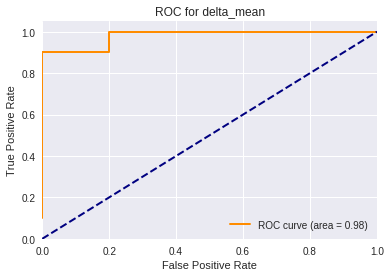

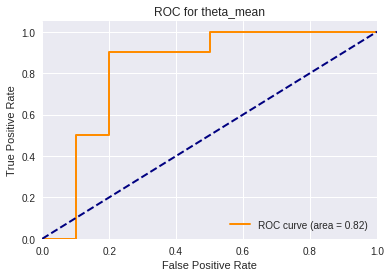

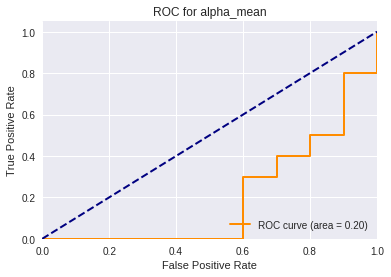

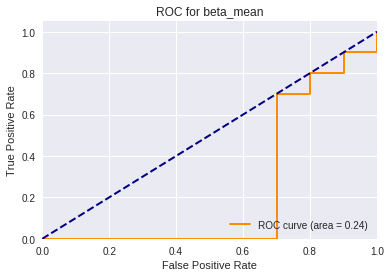

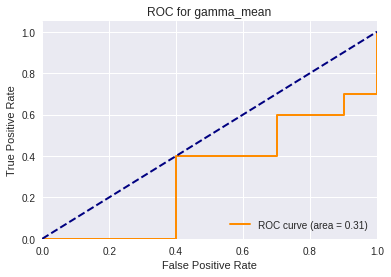

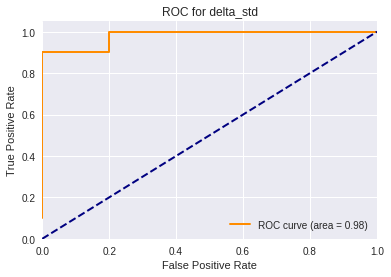

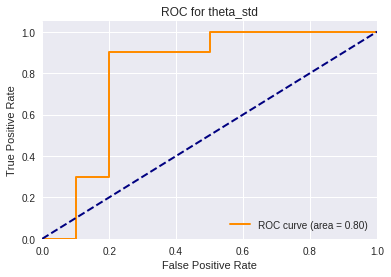

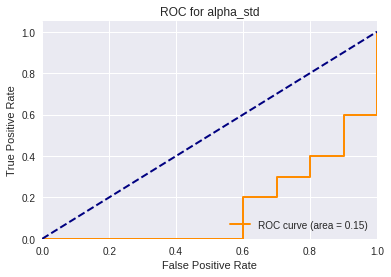

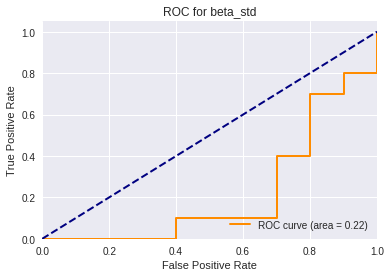

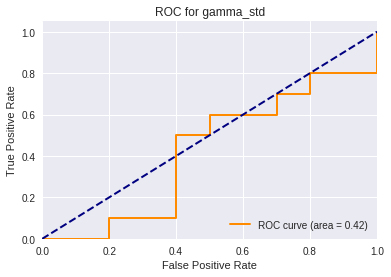

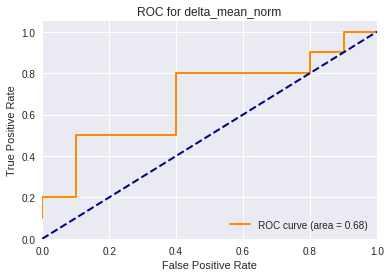

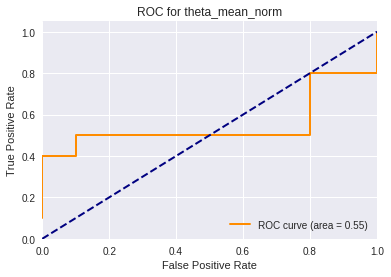

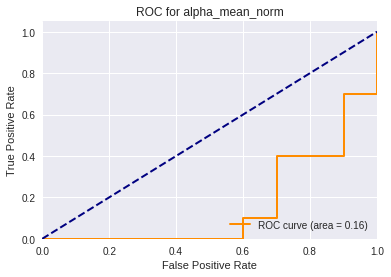

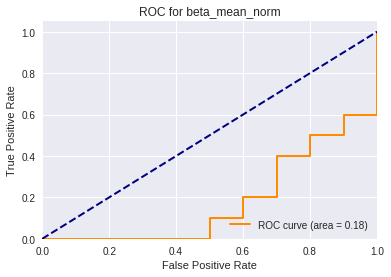

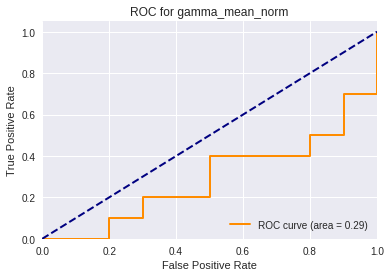

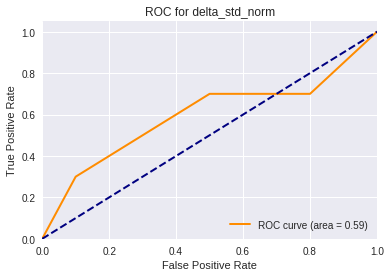

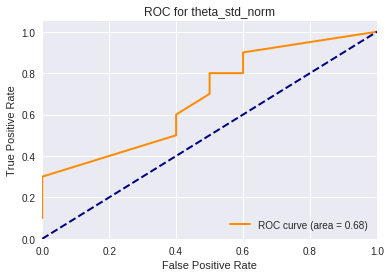

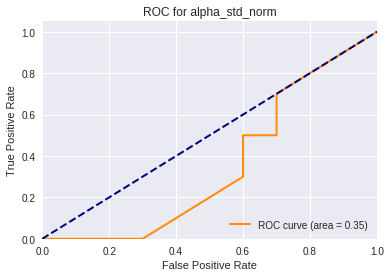

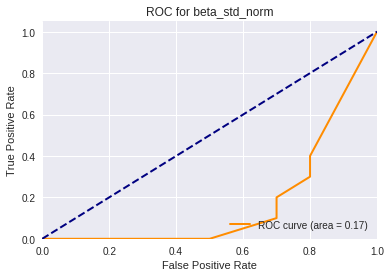

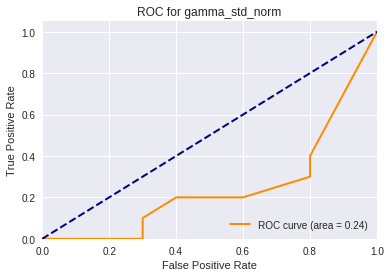

In [51]:
for feature in features:
    graficar_roc(feature,tabla[feature].values,tabla['labels'].values, 0)


#### Logistic Regression

In [52]:
def calculate_Accuarcy(clf,K_fold,save,diccionario):
    for feature in features:
        X = tabla.loc[:,feature].values.reshape(-1, 1)
        y = tabla.loc[:,'labels']
        scores = cross_val_score(clf, X,y, cv=K_fold)
        if save :
            diccionario[feature + '_Accuracy_mean'].append(scores.mean())
            diccionario[feature + '_Accuracy_std'].append(scores.std())
        else:
            print("Accuracy %s : %0.2f (+/- %0.2f)" % (feature,scores.mean(), scores.std() * 2))

def calculate_Accuarcy_All(clf,K_fold,save,diccionario):
    # X son todas los features con sus respectivos valores para cada sample
    X = tabla.iloc[:,:-1]
    # Y son todos los labels de los samples, representados como 0 si es un paciente P y 1 si es un paciente de tipo S
    y = tabla.loc[:,'labels']
    # print(Y)
#    clf = svm.SVC()
    scores = cross_val_score(clf, X,y, cv=K_fold)
    if save :
        diccionario['All_Features_Accuracy_mean'].append(scores.mean())
        diccionario['All_Features_Accuracy_std'].append(scores.std())
    else:
        # El score promedio y el intervalo de confianza con 95% del score estimado
        print("Accuracy %s: %0.2f (+/- %0.2f)" % ('con todos los features',scores.mean(), scores.std() * 2))


def new_dict():
    di = dict()
    di['All_Features_Accuracy_mean'] = []
    di['All_Features_Accuracy_std'] = []
    for feature in features:
            di[feature + '_Accuracy_mean'] = []
            di[feature + '_Accuracy_std'] = []
    return di

def plot_mean_and_std(feature,means,stds):
    x = np.arange(2,10)
    y = means
    e = stds

    plt.errorbar(x, y, e, linestyle='None', marker='^', ecolor='orange', uplims=True, lolims=True)
    plt.xlabel('K_Fold')
    plt.ylabel('Accuarcy')
    plt.title(feature)

    plt.show()

/home/julio/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/julio/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


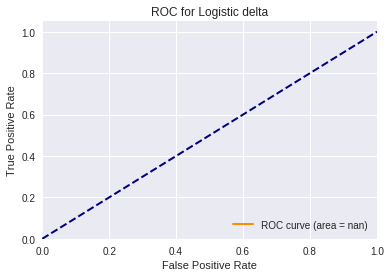

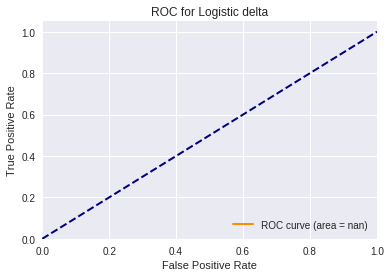

In [56]:
# PRUEBA DE GUERSON

clf = LogisticRegression()


feature = 'delta_mean'
X =  tabla.loc[:,feature]
y = tabla.loc[:,'labels']
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index].values.reshape(-1, 1), X[test_index].values.reshape(-1, 1)
    y_train, y_test = y[train_index].values.reshape(-1, 1), y[test_index].values.reshape(-1, 1)
    clf = LogisticRegression().fit(X_train, y_train)
    y_predicted = [y for y in clf.predict(X_test)]
    y_test = [val for sublist in y_test for val in sublist]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted, pos_label=1, drop_intermediate=False)
    
    graficar_roc('Logistic delta',y_test,y_predicted,0)


In [53]:
clf = LogisticRegression()

calculate_Accuarcy(clf,3,False,{})

Accuracy delta_mean : 0.89 (+/- 0.16)
Accuracy theta_mean : 0.74 (+/- 0.20)
Accuracy alpha_mean : 0.79 (+/- 0.18)
Accuracy beta_mean : 0.83 (+/- 0.27)
Accuracy gamma_mean : 0.58 (+/- 0.36)
Accuracy delta_std : 0.78 (+/- 0.31)
Accuracy theta_std : 0.83 (+/- 0.27)
Accuracy alpha_std : 0.79 (+/- 0.18)
Accuracy beta_std : 0.74 (+/- 0.20)
Accuracy gamma_std : 0.46 (+/- 0.12)
Accuracy delta_mean_norm : 0.26 (+/- 0.34)
Accuracy theta_mean_norm : 0.44 (+/- 0.16)
Accuracy alpha_mean_norm : 0.74 (+/- 0.34)
Accuracy beta_mean_norm : 0.75 (+/- 0.14)
Accuracy gamma_mean_norm : 0.60 (+/- 0.14)
Accuracy delta_std_norm : 0.61 (+/- 0.31)
Accuracy theta_std_norm : 0.58 (+/- 0.49)
Accuracy alpha_std_norm : 0.64 (+/- 0.44)
Accuracy beta_std_norm : 0.72 (+/- 0.42)
Accuracy gamma_std_norm : 0.65 (+/- 0.04)


### Análisis Multivariado
#### Support Vector Machine
Veamos como varia la presicion en función de los K_Folds utilizados

In [62]:
calculate_Accuarcy_All(clf,3,False,{})

Accuracy con todos los features: 0.89 (+/- 0.31)


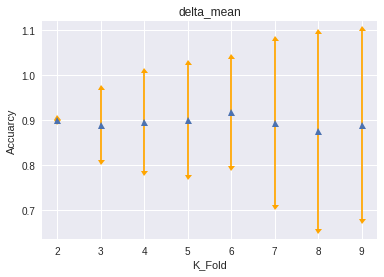

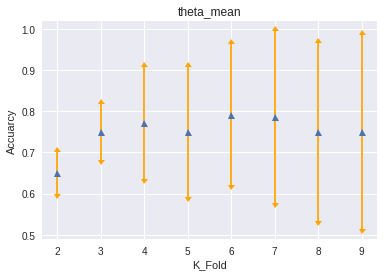

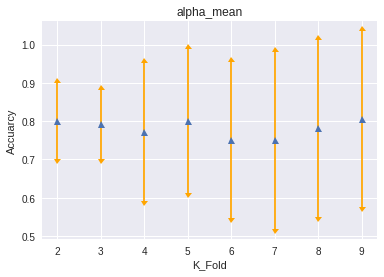

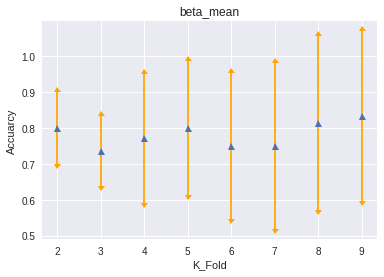

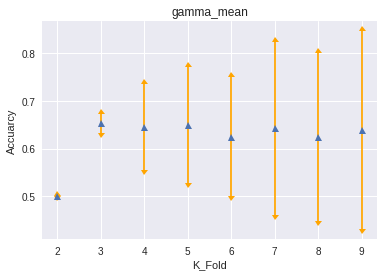

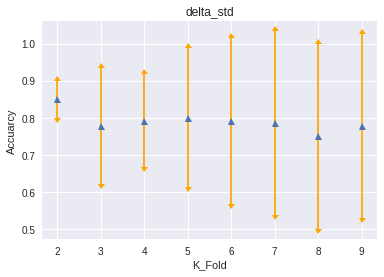

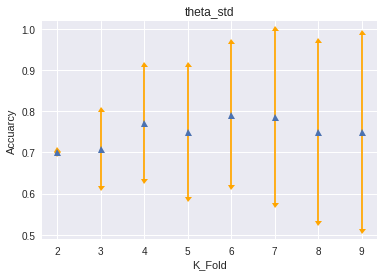

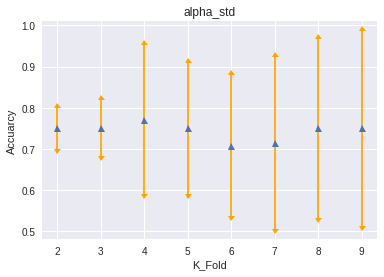

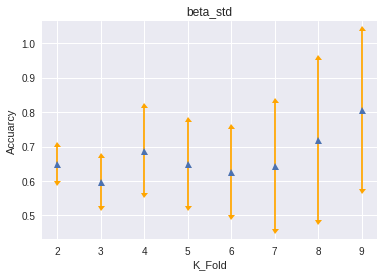

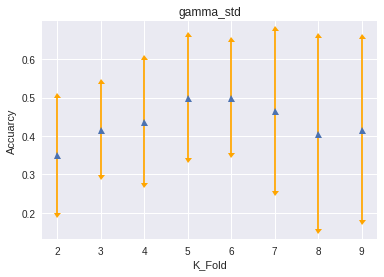

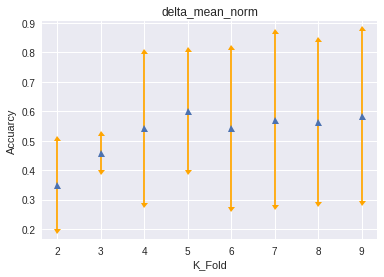

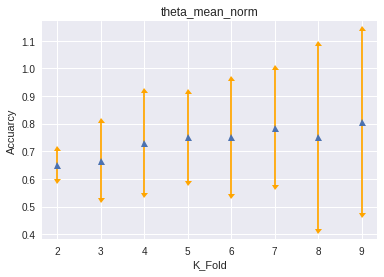

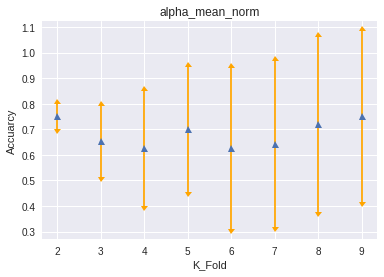

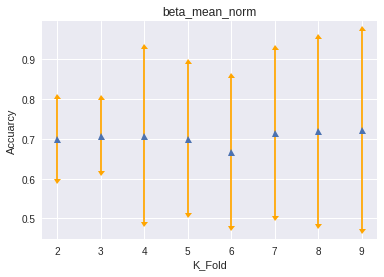

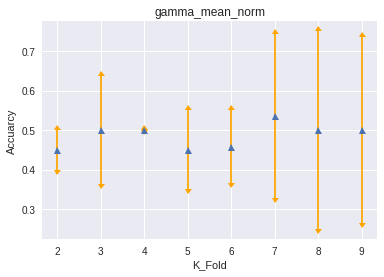

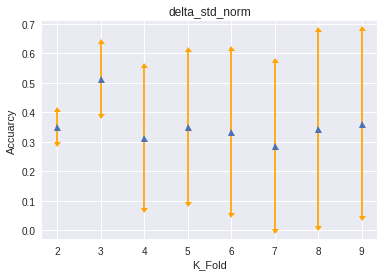

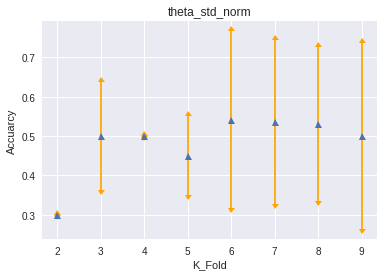

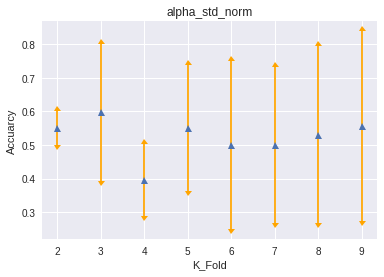

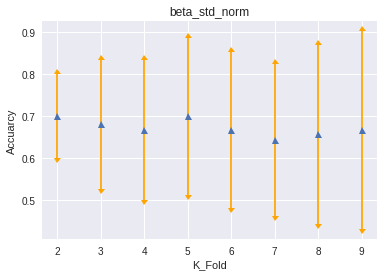

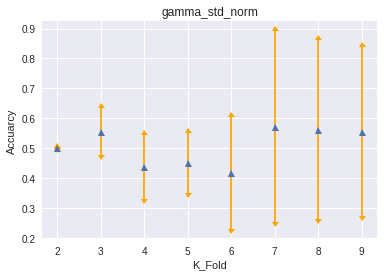

In [63]:
Accuarcy_dict = new_dict()

clf = svm.SVC()

for i in range(2,10):
    calculate_Accuarcy(clf,i,True,Accuarcy_dict)
    calculate_Accuarcy_All(clf,i,True,Accuarcy_dict)
    
for feature in features:
    plot_mean_and_std(feature,Accuarcy_dict[feature + '_Accuracy_mean'],Accuarcy_dict[feature + '_Accuracy_std'])


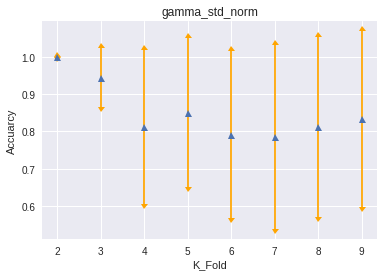

In [64]:
plot_mean_and_std(feature,Accuarcy_dict['All_Features_Accuracy_mean'],Accuarcy_dict['All_Features_Accuracy_std'])

#### Pipelin

In [58]:
X = tabla.iloc[:,:-1]
y = tabla.loc[:,'labels']


selection_filter = SelectPercentile(f_classif, percentile=10)
scaler = StandardScaler()
percentiles = [10,15,20,25,30,35,40,45,50,70]
clf = svm.SVC(kernel='linear')

pipe_svm = Pipeline([('scaler',scaler),('selection',selection_filter),('svc', clf)])
for percentile in percentiles:
    pipe_svm.set_params( selection__percentile=percentile ).fit(X, y)
    prediction = pipe_svm.predict(X)
    scores = cross_val_score(pipe_svm,X,y,cv=3)
    print("percentile {0} : Accuracy %0.2f (+- %0.2f) ".format(percentile) %  (scores.mean(),scores.std() *2))

percentile 10 : Accuracy 0.78 (+- 0.31) 
percentile 15 : Accuracy 0.79 (+- 0.18) 
percentile 20 : Accuracy 0.89 (+- 0.31) 
percentile 25 : Accuracy 1.00 (+- 0.00) 
percentile 30 : Accuracy 1.00 (+- 0.00) 
percentile 35 : Accuracy 1.00 (+- 0.00) 
percentile 40 : Accuracy 0.89 (+- 0.31) 
percentile 45 : Accuracy 0.89 (+- 0.31) 
percentile 50 : Accuracy 0.89 (+- 0.31) 
percentile 70 : Accuracy 0.94 (+- 0.16) 


Si la cantidad de features que utilizamos es muy grande, incrementa la complejidad del modelo, pero tambien incrementa la cantidad de datos que necesitamos utilizar para entrenar. 